# Density characteristics of areas near Metro rail stations
* Policies: CA State Senate Bill 827 and Senate Bill 50 both failed in their attempts to "upzone" areas around rail stations
* By relaxing the zoning restrictions on density, height, and parking minimums, areas around rail stations can become denser (land use and transportation are linked)
* Do some existing conditions around LA Metro rail stations
    * Look at census blocks within 0.5 mile of a rail station
    * Calculate average housing, population, and employment densities
    * Which are areas that would be impacted from a policy change?
* Use census blocks as our "base" file, then attach information from various data sources, including:
    * American Community Survey
    * Smart Location Database
    * Metro rail line and station locations

In [1]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import intake
import os
import geopandas as gpd
import altair.vegalite.v2 as alt
import folium
import xlsxwriter

In [3]:
cd demo/

[Errno 2] No such file or directory: 'demo/'
/home/jovyan/demo


## I. Import files
* Clip the geodataframes to LA County
* Only keep columns we need to build table
### A. Census block base (Census TIGER shapefile, 2018)

In [4]:
block = gpd.read_file('./gis/cb_2018_06_bg_500k/')

In [5]:
# Only keep LA County and project to CA State Plane
block = block[block.COUNTYFP=='037'][['GEOID', 'geometry']].to_crs({'init':'epsg:2229'})

### B. American Community Survey (ACS 5-yr 2013-2017 tabular data)
* Unit of geography: block groups in LA County
* B25001 - number of housing units
* B25008 - population by owner vs renter occupied units

In [6]:
units = pd.read_csv('./data/ACS_17_5YR_B25001_with_ann.csv')
pop = pd.read_csv('./data/ACS_17_5YR_B25008_with_ann.csv')

In [7]:
units.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_VD01,HD02_VD01
0,Id,Id2,Geography,Estimate; Total,Margin of Error; Total
1,1500000US060371011101,060371011101,"Block Group 1, Census Tract 1011.10, Los Angel...",668,91
2,1500000US060371011102,060371011102,"Block Group 2, Census Tract 1011.10, Los Angel...",685,95
3,1500000US060371011103,060371011103,"Block Group 3, Census Tract 1011.10, Los Angel...",379,86
4,1500000US060371011221,060371011221,"Block Group 1, Census Tract 1011.22, Los Angel...",798,89


In [8]:
pop.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_VD01,HD02_VD01,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03
0,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Total: - Owner occupied,Margin of Error; Total: - Owner occupied,Estimate; Total: - Renter occupied,Margin of Error; Total: - Renter occupied
1,1500000US060371011101,060371011101,"Block Group 1, Census Tract 1011.10, Los Angel...",1804,364,1073,313,731,261
2,1500000US060371011102,060371011102,"Block Group 2, Census Tract 1011.10, Los Angel...",1717,333,460,183,1257,351
3,1500000US060371011103,060371011103,"Block Group 3, Census Tract 1011.10, Los Angel...",953,256,656,224,297,174
4,1500000US060371011221,060371011221,"Block Group 1, Census Tract 1011.22, Los Angel...",1956,388,1585,348,371,245


In [9]:
# Rename columns
units.rename(columns={'GEO.id2': 'geoid', 'HD01_VD01': 'housing_units'}, inplace=True)
pop.rename(columns={'GEO.id2': 'geoid', 'HD01_VD01': 'pop', 
                   'HD01_VD02':'owner_pop', 'HD01_VD03': 'renter_pop'}, inplace=True)

# Drop 1st row
units = units.drop(units.index[0])
pop = pop.drop(pop.index[0])

# Drop columns
units = units[['geoid', 'housing_units']]
pop = pop[['geoid', 'pop', 'owner_pop', 'renter_pop']]

In [10]:
# Change data types
units = units.astype({'geoid':'str', 'housing_units':'int32'})
pop = pop.astype({'geoid':'str', 'pop': 'int32', 'owner_pop': 'int32', 'renter_pop': 'int32'})

### C. EPA Smart Location Database (2010)
* [Smart Location Database](https://www.epa.gov/smartgrowth/smart-location-mapping)
* [User Guide](https://www.epa.gov/sites/production/files/2014-03/documents/sld_userguide.pdf)
* Variables are derived from Census Longitudinal Employer-Household Dynamics (2010) data

In [11]:
sld = gpd.read_file('./gis/Smart_Location_Database/')

In [12]:
# Just keep subset of columns and only keep rows that belong to LA County (State FIPS = 06; County FIPS = 037)
"""
EMPTOT - total employment
D5br - # jobs within 45 min transit commute
"""
keep = ['GEOID10', 'EMPTOT', 'D5br']
sld = sld[(sld.SFIPS=='06') & (sld.CFIPS=='037')][keep]

In [13]:
sld.rename(columns={'GEOID10': 'geoid', 'EMPTOT': 'emp', 'D5br': 'jobs45'}, inplace=True)
sld = sld.astype({'geoid':'str'})

In [14]:
sld.head()

,geoid,emp,jobs45
2142,060372932023,1601.0,6815.07
2143,060372941201,302.0,11741.45
2144,060372932022,76.0,7996.35
2145,060372932021,20.0,9447.40
2146,060372941101,84.0,9042.51


### D. Metro Rail Lines and Stations
* [LA Metro GIS data](https://developer.metro.net/introduction/gis-data/download-gis-data/)

In [15]:
lines = gpd.read_file('./gis/Metro_Rail_Lines.geojson')
stations = gpd.read_file('./gis/Stations_All_0316/')

In [16]:
lines = lines[['Id', 'geometry']].to_crs({'init':'epsg:2229'})
stations = stations[['LINE', 'LINENUM', 'STOPNUM', 'geometry']].to_crs({'init':'epsg:2229'})

In [17]:
stations.LINE.value_counts()

Gold          27
Blue          20
EXPO          17
Green         14
Red            8
Red/Purple     6
Purple         2
Blue/EXPO      2
Name: LINE, dtype: int64

In [18]:
stations.LINE = stations['LINE'].str.replace('EXPO', 'Expo')

## II. Merge files at the census block level
* Use census block group as the base
* Attach ACS and SLD data 

In [19]:
merge1 = pd.merge(block, units, left_on = 'GEOID', right_on = 'geoid', how='left', validate='1:1', indicator=True)
merge1.head()

,GEOID,geometry,geoid,housing_units,_merge
0,060375766021,(POLYGON ((6508302.089017047 1737063.390336079...,060375766021,1147,both
1,060371347203,"POLYGON ((6387704.357979584 1898693.448563642,...",060371347203,576,both
2,060371254023,"POLYGON ((6447020.364304705 1881120.831268478,...",060371254023,893,both
3,060375338033,"POLYGON ((6505830.883794739 1814325.136324333,...",060375338033,345,both
4,060372122042,"POLYGON ((6474107.097197829 1843873.789287847,...",060372122042,732,both


In [20]:
# Check that everything merged.
merge1['_merge'].value_counts()

both          6423
right_only       0
left_only        0
Name: _merge, dtype: int64

In [21]:
merge2 = pd.merge(merge1, pop, on='geoid', how='left')

In [22]:
merge3 = pd.merge(merge2, sld, on='geoid', how='left')
merge3.head()

,GEOID,geometry,geoid,housing_units,_merge,pop,owner_pop,renter_pop,emp,jobs45
0,060375766021,(POLYGON ((6508302.089017047 1737063.390336079...,060375766021,1147,both,1676,444,1232,49.0,0.00
1,060371347203,"POLYGON ((6387704.357979584 1898693.448563642,...",060371347203,576,both,1253,438,815,50.0,14939.66
2,060371254023,"POLYGON ((6447020.364304705 1881120.831268478,...",060371254023,893,both,1901,257,1644,186.0,27721.89
3,060375338033,"POLYGON ((6505830.883794739 1814325.136324333,...",060375338033,345,both,1289,444,845,46.0,19925.90
4,060372122042,"POLYGON ((6474107.097197829 1843873.789287847,...",060372122042,732,both,1932,100,1832,65.0,80126.04


In [23]:
df = merge3.copy()
df = df.drop(columns=['_merge', 'geoid'])

## III. Draw 0.5 mi buffer around Metro rail stations
* Any census blocks that intersect with this 0.5 mi buffer will be included in the blocks we want to map
* Tag the census blocks that overlap with the buffers
* Also tag the rail lines that they overlap with (can have multiple rail lines, esp in Downtown core)

In [24]:
# All my geodataframes are in EPSG:2229, CA State Plane (units are in feet)
stations_buffer = stations
stations_buffer['geometry'] = stations_buffer.geometry.buffer(2640)

In [25]:
# Do spatial join of census blocks with station buffer. 'inner' means that those that intersect are kept in the joined df.
buffer_join = gpd.sjoin(block, stations_buffer, how='inner', op='intersects')

In [26]:
# Each census block can overlap with the buffers for multiple rail lines (i.e Downtown core)
# Flag all possible lines that block overlaps with
rail_lines = ['Blue', 'Red', 'Purple', 'Green', 'Gold', 'Expo']

for rail in rail_lines:
    buffer_join[rail] = buffer_join.LINE.str.contains(rail)
    buffer_join[rail] = buffer_join[rail].astype(int)

In [27]:
# Use max to find whether or not that rail line's buffer intersects that block.
# It's possible for a block to intersect with multiple stations' buffers (i.e 2 Expo/Blue Line stations, but only want to tag Expo and Blue each once) 
pivot = buffer_join.pivot_table(index='GEOID', values=['Blue', 'Red', 'Purple', 'Green', 'Gold', 'Expo'], aggfunc='max').reset_index()
pivot.head()

,GEOID,Blue,Expo,Gold,Green,Purple,Red
0,060371241022,0,0,0,0,0,1
1,060371242041,0,0,0,0,0,1
2,060371242042,0,0,0,0,0,1
3,060371243003,0,0,0,0,0,1
4,060371252001,0,0,0,0,0,1


In [28]:
# Generate dummy variable called keep_block now. When this smaller subset is merged with census block file, 
# I can easily see which ones are the blocks I want to keep.
pivot['keep_block'] = 1
pivot.head()

,GEOID,Blue,Expo,Gold,Green,Purple,Red,keep_block
0,060371241022,0,0,0,0,0,1,1
1,060371242041,0,0,0,0,0,1,1
2,060371242042,0,0,0,0,0,1,1
3,060371243003,0,0,0,0,0,1,1
4,060371252001,0,0,0,0,0,1,1


In [29]:
base = pd.merge(block, pivot, on='GEOID', how='left', validate='1:1')

In [30]:
base['keep_block'] = base.keep_block.fillna(0)

## IV. Assemble dataset of census blocks with all the information attached

In [31]:
gdf = pd.merge(base, df, on='GEOID', how='left')

In [32]:
gdf = gdf.drop(columns=['geometry_y'])
gdf.rename(columns = {'geometry_x': 'geometry'}, inplace=True)

In [33]:
gdf = gdf[gdf.keep_block == 1]

#### Normalize variables by area

In [34]:
feet_in_acres = 43560
gdf['acres'] = gdf.geometry.area / feet_in_acres

In [35]:
for col in ['housing_units', 'pop', 'owner_pop', 'renter_pop', 'emp']:
    new_col = f"{col}_acre"
    gdf[new_col] = gdf[col] / gdf.acres

In [36]:
gdf.head()

,GEOID,geometry,Blue,Expo,Gold,Green,Purple,Red,keep_block,housing_units,...,owner_pop,renter_pop,emp,jobs45,acres,housing_units_acre,pop_acre,owner_pop_acre,renter_pop_acre,emp_acre
4,060372122042,"POLYGON ((6474107.097197829 1843873.789287847,...",0.0,0.0,0.0,0.0,1.0,1.0,1.0,732,...,100,1832,65.0,80126.04,14.898943,49.131002,129.673627,6.711885,122.961742,4.362726
6,060372094031,"POLYGON ((6478507.520417627 1842668.155661697,...",0.0,0.0,0.0,0.0,1.0,1.0,1.0,787,...,0,1629,186.0,101304.10,17.494330,44.986004,93.115883,0.000000,93.115883,10.632016
7,060375327001,"POLYGON ((6486564.571323734 1818650.980400814,...",1.0,0.0,0.0,0.0,0.0,0.0,1.0,363,...,480,1087,227.0,41375.86,62.610415,5.797757,25.027785,7.666456,17.361329,3.625595
9,060372117032,"POLYGON ((6466547.774524551 1847625.203366093,...",0.0,0.0,0.0,0.0,1.0,0.0,1.0,898,...,385,1554,32.0,58167.30,22.762982,39.450015,85.182160,16.913425,68.268735,1.405791
15,060372220021,"POLYGON ((6465418.791555855 1831829.104294554,...",0.0,1.0,0.0,0.0,0.0,0.0,1.0,483,...,510,963,90.0,35017.87,41.324583,11.687958,35.644643,12.341322,23.303321,2.177880


In [37]:
housing_series = gdf[['GEOID', 'housing_units_acre']]

m = folium.Map(
    location=[34.0536, -118.2427], 
    zoom_start=10, 
    tiles='cartodbpositron'
)


# Add the color for the chloropleth:
m.choropleth(
 geo_data=gdf[['GEOID', 'geometry']],
 name='choropleth',
 data=housing_series,
 columns=['GEOID', 'housing_units_acre'],
 key_on='feature.GEOID',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Housing Density'
)
folium.LayerControl().add_to(m)

m

/opt/conda/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


#### Export as GeoJSON

In [38]:
gdf.to_file(driver = 'GeoJSON', filename = './gis/census_block_characteristics_near_rail.geojson')

## V. Make charts

In [39]:
subset = ['housing_units_acre', 'pop_acre', 'owner_pop_acre', 'renter_pop_acre', 'emp_acre']
gdf[subset].describe()

,housing_units_acre,pop_acre,owner_pop_acre,renter_pop_acre,emp_acre
count,924.000000,924.000000,924.000000,924.000000,924.000000
mean,12.534514,31.638994,6.519117,25.119878,11.480536
std,12.960340,27.680355,5.477890,28.040910,28.276809
min,0.000000,0.000000,0.000000,0.000000,0.066190
25%,4.766396,13.530716,2.395970,6.792921,1.524338
50%,8.241593,24.669798,5.460433,17.051572,4.201416
75%,14.882577,40.298447,9.566404,31.003942,10.357476
max,128.616616,183.616188,33.693366,183.616188,573.842974


In [40]:
# Create smaller dfs for each line, then append them into one df again
line_dfs = {}
all = pd.DataFrame()

for line in ['Blue', 'Red', 'Purple', 'Green', 'Gold', 'Expo']:
    line_dfs[line] = gdf[gdf[line]==1]

for key, value in line_dfs.items():
    value['line'] = key
    all = all.append(value)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [41]:
all2 = all.drop(columns='geometry')

In [42]:
summary = all.pivot_table(index='line', values=['housing_units_acre', 'pop_acre', 'emp_acre'], aggfunc='mean').reset_index()
summary

,line,emp_acre,housing_units_acre,pop_acre
0,Blue,11.091128,10.777152,30.970465
1,Expo,16.827616,11.849298,25.467525
2,Gold,11.557992,7.548515,20.653190
3,Green,3.711368,5.934864,21.429969
4,Purple,34.444623,32.514046,72.318415
5,Red,24.568236,24.497621,52.314813


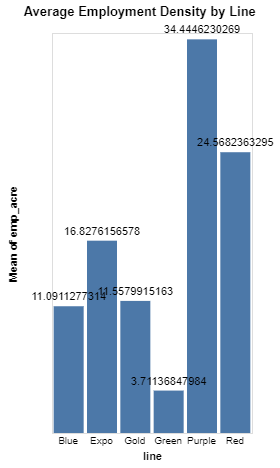

In [43]:
# Title
bar=alt.Chart(all2).mark_bar().encode(
    x=alt.X(
        'line',
        sort=alt.EncodingSortField(
            field='emp_acre',
            op='mean',
            order='descending'
        )
    ), 
    y='mean(emp_acre):Q'
)
       
text=bar.mark_text(
    align='center',
    baseline='top',
    dy=-15
).encode(
    text='mean(emp_acre):Q'
)

alt.layer(bar, text).configure_view(
    strokeOpacity=0, strokeWidth=0).configure(
    countTitle=' ').configure_axis(
    grid=False, ticks=False, labelAngle=0, domainWidth=0).configure_axisY(
    labelColor='white').properties(
    height=400, width=200, title='Average Employment Density by Line')

In [44]:
# Create a pandas Excel writer using xlsxWriter as the engine.
writer = pd.ExcelWriter('summary_statistics.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
summary.to_excel(writer, sheet_name='summary')

writer.save()